<a href="https://colab.research.google.com/github/1zpzz/QM2-Website-/blob/main/QM2_Differences_in_Differences_GunLaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
population_df = pd.read_csv('/content/Public v3 (4).csv')
population_df['Population'] = population_df['Population'].astype(str).str.replace(',', '', regex=False)
population_df['Population'] = pd.to_numeric(population_df['Population'], errors='coerce')

# Reload the original dataset to ensure 'Year' and 'State' columns are present
df = pd.read_csv('/content/Public v3 (3).csv')
grouped_shootings = df.groupby(['Year', 'State']).size().reset_index(name='Shooting_Count')

# Merge the shootings data with the population data
merged_df = pd.merge(grouped_shootings, population_df, on='State', how='left')

merged_df['Shootings_per_100k'] = (merged_df['Shooting_Count'] / merged_df['Population']) * 100000
pivot_table = merged_df.pivot(index='State', columns='Year', values='Shootings_per_100k')

# Replace NaN values with 0
pivot_table = pivot_table.fillna(0)

pivot_table.to_csv('shootings_per_100k_per_year.csv')
print("\nCleaned Dataset (Preview):")
print(pivot_table.head())


Cleaned Dataset (Preview):
Year   1966.000000000000000  1967.000000000000000  1968.000000000000000  \
State                                                                     
AK        0.000000000000000     0.000000000000000     0.000000000000000   
AL        0.000000000000000     0.000000000000000     0.000000000000000   
AR        0.000000000000000     0.000000000000000     0.000000000000000   
AZ        0.000000000000000     0.000000000000000     0.000000000000000   
CA        0.005132786073971     0.000000000000000     0.002566393036986   

Year   1969.000000000000000  1970.000000000000000  1971.000000000000000  \
State                                                                     
AK        0.000000000000000     0.000000000000000     0.000000000000000   
AL        0.000000000000000     0.000000000000000     0.000000000000000   
AR        0.000000000000000     0.032597371608732     0.000000000000000   
AZ        0.000000000000000     0.000000000000000     0.013456516075692

In [ ]:
import matplotlib.pyplot as plt
df = pd.read_csv('shootings_per_100k_per_year.csv')
# Melt the data into long format for easier processing
df_long = df.melt(id_vars='State', var_name='Year', value_name='Shooting_Count')
# Convert 'Year' column to numeric, handling errors by coercing to NaN
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
# Convert 'Year' column to integers, ignoring NaN values
df_long['Year'] = df_long['Year'].astype(int, errors='ignore')
df_long['Year'] = df_long['Year'].astype(int)  # Ensure Year is an integer

<ipython-input-84-560ad315f25d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Post'] = (df_filtered['Year'] >= 2019).astype(int)
<ipython-input-84-560ad315f25d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Interaction'] = df_filtered['Group'].apply(lambda x: 1 if x == 'Treated' else 0) * df_filtered['Post']


                            OLS Regression Results                            
Dep. Variable:     Shootings_per_100k   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     448.9
Date:                Wed, 15 Jan 2025   Prob (F-statistic):          1.60e-238
Time:                        16:58:56   Log-Likelihood:                 6043.1
No. Observations:                2832   AIC:                        -1.208e+04
Df Residuals:                    2828   BIC:                        -1.205e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

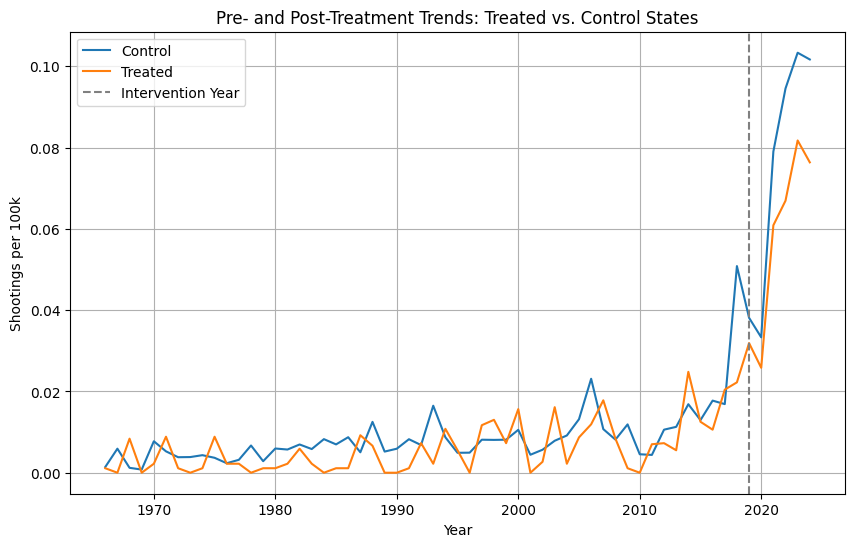

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pivot_table = pd.read_csv('shootings_per_100k_per_year.csv')
df_long = pivot_table.melt(id_vars=['State'], var_name='Year', value_name='Shootings_per_100k')
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Define treated and control states (update based on your treated vs control group selection)
treated_states = ['FL','NJ','OK', 'OR']  # Replace with your treated states that have put the
control_states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'DE', 'GA', 'HI', 'IA', 'ID',
    'IL', 'IN', 'KS', 'LA', 'MA', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC',
    'ND', 'NE', 'NH', 'NM', 'NV', 'NY', 'OH', 'RI', 'SD',
    'UT', 'VA', 'VT', 'WI', 'WV', 'WY', 'TN','TX','PA', 'CT', 'MD', 'SC']

# Add a group column: 'Treated' for treated states, 'Control' for control states
df_long['Group'] = df_long['State'].apply(
    lambda x: 'Treated' if x in treated_states else 'Control' if x in control_states else 'Excluded'
)

# Filter only treated and control states
df_filtered = df_long[df_long['Group'] != 'Excluded']

# Add a post-treatment indicator (assuming the intervention was operational in 2019)
df_filtered['Post'] = (df_filtered['Year'] >= 2019).astype(int)

# Interaction term for DiD
df_filtered['Interaction'] = df_filtered['Group'].apply(lambda x: 1 if x == 'Treated' else 0) * df_filtered['Post']

# DiD regression using statsmodels
model = smf.ols('Shootings_per_100k ~ C(Group) * Post', data=df_filtered).fit()

# Print regression results
print(model.summary())

# Plot pre-treatment trends for visual inspection
plt.figure(figsize=(10, 6))

# Group data for plotting
grouped_trends = df_filtered.groupby(['Year', 'Group'])['Shootings_per_100k'].mean().reset_index()

# Plot trends for treated and control groups
for group in grouped_trends['Group'].unique():
    subset = grouped_trends[grouped_trends['Group'] == group]
    plt.plot(subset['Year'], subset['Shootings_per_100k'], label=group)

# Mark the intervention year
plt.axvline(x=2019, color='gray', linestyle='--', label='Intervention Year')

# Customize the plot
plt.title('Pre- and Post-Treatment Trends: Treated vs. Control States')
plt.xlabel('Year')
plt.ylabel('Shootings per 100k')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import statsmodels.formula.api as smf

# Add an interaction term (Post * Treatment) to test the causal effect
df_filtered['Post'] = (df_filtered['Year'] >= 2019).astype(int)
df_filtered['Interaction'] = df_filtered['Post'] * (df_filtered['Group'] == 'Treated').astype(int)

# Fit the Difference-in-Differences regression model
model = smf.ols('Shootings_per_100k ~ Post + (Group == "Treated") + Interaction', data=df_filtered).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     Shootings_per_100k   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     448.9
Date:                Wed, 15 Jan 2025   Prob (F-statistic):          1.60e-238
Time:                        17:00:36   Log-Likelihood:                 6043.1
No. Observations:                2832   AIC:                        -1.208e+04
Df Residuals:                    2828   BIC:                        -1.205e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<ipython-input-85-a4b60e380418>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Post'] = (df_filtered['Year'] >= 2019).astype(int)
<ipython-input-85-a4b60e380418>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Interaction'] = df_filtered['Post'] * (df_filtered['Group'] == 'Treated').astype(int)


In [ ]:
# Define the states and treatment year
reated_states = ['FL','NJ','OK', 'OR']  # Replace with your treated states that have put the
control_states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'DE', 'GA', 'HI', 'IA', 'ID',
    'IL', 'IN', 'KS', 'LA', 'MA', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC',
    'ND', 'NE', 'NH', 'NM', 'NV', 'NY', 'OH', 'RI', 'SD',
    'UT', 'VA', 'VT', 'WI', 'WV', 'WY', 'TN','TX','PA', 'CT', 'MD', 'SC']
treatment_year = 2019

# Add a binary column to indicate treatment group
merged_df['Treatment'] = merged_df['State'].apply(lambda x: 1 if x in treatment_states else 0)

# Add a binary column to indicate post-treatment period
merged_df['Post'] = merged_df['Year'].apply(lambda x: 1 if x >= treatment_year else 0)

# Filter relevant states for analysis
analysis_df = merged_df[merged_df['State'].isin(treatment_states + control_states)]

# Save the analysis dataset for later use
analysis_df.to_csv('analysis_dataset.csv')

# Preview the dataset
print(analysis_df.head())

                  Year State  Shooting_Count               Population  \
0 1966.000000000000000    CA               2 38965193.000000000000000   
1 1966.000000000000000    FL               1 22610726.000000000000000   
2 1966.000000000000000    MN               1  5737915.000000000000000   
3 1966.000000000000000    NC               1 10835491.000000000000000   
4 1966.000000000000000    NY               1 19571216.000000000000000   

   Shootings_per_100k  Treatment  Post  
0   0.005132786073971          0     0  
1   0.004422679749425          1     0  
2   0.017427933317242          0     0  
3   0.009228931111659          0     0  
4   0.005109544547462          0     0  


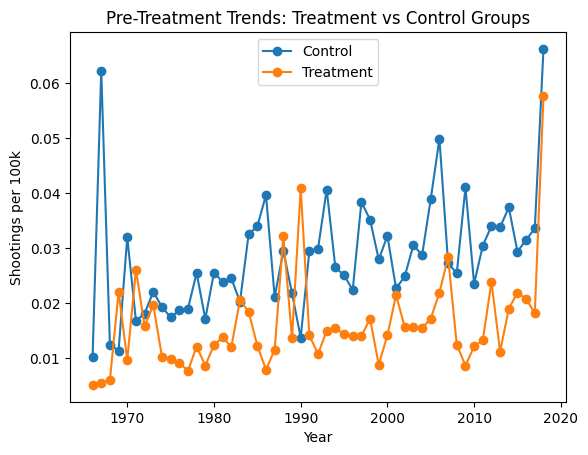

                            OLS Regression Results                            
Dep. Variable:     Shootings_per_100k   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     25.89
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           5.72e-16
Time:                        17:01:01   Log-Likelihood:                 1711.9
No. Observations:                 779   AIC:                            -3416.
Df Residuals:                     775   BIC:                            -3397.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<ipython-input-87-a6e3e788e8f9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_treatment_data['Year_Treatment_Interaction'] = pre_treatment_data['Year'] * pre_treatment_data['Treatment']


In [ ]:
import matplotlib.pyplot as plt

# Calculate mean shootings per 100k for treatment and control groups
pre_trends = analysis_df[analysis_df['Year'] < treatment_year]
group_trends = pre_trends.groupby(['Year', 'Treatment'])['Shootings_per_100k'].mean().unstack()

# Plot the trends
group_trends.plot(title='Pre-Treatment Trends: Treatment vs Control Groups', marker='o')
plt.xlabel('Year')
plt.ylabel('Shootings per 100k')
plt.legend(['Control', 'Treatment'])
plt.show()

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Subset data for pre-treatment period
pre_treatment_data = analysis_df[analysis_df['Year'] < treatment_year]

# Add an interaction term for Year and Treatment
pre_treatment_data['Year_Treatment_Interaction'] = pre_treatment_data['Year'] * pre_treatment_data['Treatment']

# Run the regression to check parallel trends
model = smf.ols(
    formula='Shootings_per_100k ~ Year + Treatment + Year_Treatment_Interaction',
    data=pre_treatment_data
).fit()

# Display results
print(model.summary())

